# Head

## imports

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function , division
from __future__ import absolute_import
from __future__ import unicode_literals

In [2]:
%matplotlib inline
import logging
import datetime
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import itertools
import glob
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
from pylab import rcParams

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, GaussianNoise
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model , np_utils
from keras.models import model_from_json
from keras.optimizers import SGD

import tensorflow as tf
from keras.backend import tensorflow_backend as K

from time import gmtime, strftime
from keras.callbacks import TensorBoard



Using TensorFlow backend.


## memoryの制限

In [3]:
# memoryの制限
config = tf.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [4]:
#GPUを認識できてるか確認
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

## Tuning

In [5]:
#Tuning
# dataset = "ModelNet10"
dataset = "ModelNet40"
n_points = 10000
cell = 32
batch_size = 128
epochs = 80
learning_rate = 0.01

In [6]:
if dataset == "ModelNet10":
    data_dir = "ModelNet10/"
    num_classes = 10
    class_name_modelnet = [
    'bathtub',
    'chair',
    'dresser',
    'night_stand',
    'table',
    'bed',
    'desk',
    'monitor',
    'sofa',
    'toilet',
    ]

In [7]:
if dataset == "ModelNet40":
    data_dir = "ModelNet40/"
    num_classes = 40
    class_name_modelnet = [
    'airplane',
    'bookshelf',
    'chair',
    'desk',
    'glass_box',
    'laptop',
    'person',
    'range_hood',
    'stool',
    'tv_stand',
    'bathtub',
    'bottle',
    'cone',
    'door',
    'guitar',
    'mantel',
    'piano',
    'sink',
    'table',
    'vase',
    'bed',
    'bowl',
    'cup',
    'dresser',
    'keyboard',
    'monitor',
    'plant',
    'sofa',
    'tent',
    'wardrobe',
    'bench',
    'car',
    'curtain',
    'flower_pot',
    'lamp',
    'night_stand',
    'radio',
    'stairs',
    'toilet',
    'xbox',
    ]

In [8]:
train_or_test = ["train","test"]

## Directory関連

In [136]:
#読み込み，書き込み用ディレクトリ
data_dir = data_dir
vox_dir = "np_vox/" + dataset + "/cell" + str(cell) + "/"
fig_dir =  "figure/"+ dataset + "/cell" + str(cell) + "/"
weights_dir = "weights/" + dataset + "/cell" + str(cell) + "/"
model_dir = "model/"+ dataset + "/cell" + str(cell) + "/"
dist_dir = "dist/"+ dataset + "/cell" + str(cell) + "/"

In [137]:
if os.path.exists(vox_dir) == False:
    os.makedirs(vox_dir)
if os.path.exists(weights_dir) == False:
    os.makedirs(weights_dir)
if os.path.exists(fig_dir) == False:
    os.makedirs(fig_dir)
if os.path.exists(model_dir) == False:
    os.makedirs(model_dir)
if os.path.exists(dist_dir) == False:
    os.makedirs(dist_dir)

# 関数

## offファイル読み込み

In [145]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")
        
    #OFFファイルが不正かどうか判定
    if off[0] != "OFF":
#         print("{} is broken!!".format(filename))
        params = list(off[0].split(" "))
        n_vertices = int(params[0].strip("OFF"))
        n_faces = int(params[1])
        off.insert(0, "OFF")
    
    else:
        #get params and faces
        params = list(map(int, off[1].split(" ")))
        n_vertices = params[0]
        n_faces = params[1]

    # read  Vertex coordinates
    vertices = []
    for n in range(n_vertices):
        coords = list(map(float, off[2+n].split()))
        vertices.append(coords)

    # read information of faces
    faces = []
    for n in range(n_faces):
        connects = list(map(int, off[2 + n_vertices + n].split(" ")[1:4]))
        faces.append(connects)

    return vertices, faces

## 点群発生系

In [12]:
def calc_vector_norm(a):
#     何も分からん
    norm = 0.0
    for el in a:
        norm += el *el
    return math.sqrt(norm)

In [13]:
def calc_cross_product_3d(a,b):
#     なんもわからん
    return [a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2],a[0]*b[1]-a[1]*b[0]]

In [14]:
def calc_triangle_area(a, b, c):
#     なんもわからん
    ca = [c[0]-a[0], c[1]-a[1], c[2]-a[2]]
    ba = [b[0]-a[0], b[1]-a[1], b[2]-a[2]]
    cross = calc_cross_product_3d(ca, ba)
    return 0.5 * calc_vector_norm(cross)

In [15]:
def calc_cumulative_areas(vertices, faces):
#     なんもわからん
    cuma = 0.0
    cum_areas = []
    for fc in faces:
        cuma += calc_triangle_area(
            vertices[fc[0]], vertices[fc[1]], vertices[fc[2]])
        cum_areas.append(cuma)
    return cum_areas

In [16]:
def random_select_face_id(cum_areas):
#     なんもわからん
    rand_area = cum_areas[-1] * random.random()
    select_id = 0
    for n in range(len(cum_areas)):
        if rand_area <= cum_areas[n]:
            select_id = n
            break
    return select_id

In [17]:
def gen_random_points(vertices, faces, n_points):
#     なんもわからん
    cum_areas = calc_cumulative_areas(vertices, faces)
    points = []
    for n in range(n_points):
        fid = random_select_face_id(cum_areas)
        r1 = math.sqrt(random.random())
        r2 = random.random()
        a = vertices[faces[fid][0]]
        b = vertices[faces[fid][1]]
        c = vertices[faces[fid][2]]
        xp = (1 - r1) * a[0] + r1 * (1 - r2) * b[0] + r1 * r2 * c[0]
        yp = (1 - r1) * a[1] + r1 * (1 - r2) * b[1] + r1 * r2 * c[1]
        zp = (1 - r1) * a[2] + r1 * (1 - r2) * b[2] + r1 * r2 * c[2]
        points.append([xp, yp, zp])
    return points

## 可視化ツール

In [18]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2],s = 2)
    ax.axis("equal")
    plt.show()

In [19]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
#         plt.xlim([-2,32]) 
#         plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()

In [20]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [21]:
def plot_confusion_matrix(data, 
                          label,
                          classes=class_name_modelnet,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    labels_pred = model.predict_classes(data,verbose=0)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), labels_pred)
    np.set_printoptions(precision=2)
    cm_normalize = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cnf_matrix.max() / 2
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
    plt.show()


## ボクセル系

In [74]:
def voxilize(np_pc,cell):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min_

        #covered cell
        cls = cell - 3

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([cell-2,cell-2,cell-2])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

#     # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
#     # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
#         if random.randint(0,100) < 80:
        vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,1,cell,cell,cell])
    np_vox[0, 0, 1:-1, 1:-1, 1:-1] = vox

    return np_vox

In [23]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[2]):
        #32回
        for y in range(0,np_vox.shape[3]):
            #32回
            for z in range(0,np_vox.shape[4]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,0,x,y,z] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

## ボクセルの読み込み

In [24]:
def load_vox(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_off(filename)
    points = gen_random_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc,cell)

    return vox

## tensorboard

In [25]:
def make_tensorboard(set_dir_name='TensorBoard'):
    log_dir = set_dir_name
    if os.path.exists(log_dir) == False:
        os.makedirs(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, )
    return tensorboard

## 距離の計算

In [88]:
# XYZ 長さの取得
def calc_dist(filename):
    vertices, faces = load_off(filename)
    point =  np.array(vertices)
    dist = np.zeros(3)
    for i in range(0,3):
        min_ = np.amin(point[:,i])
        max_ = np.amax(point[:,i])
        dist_ = max_ - min_
        dist[i] = dist_
    return dist

# ボクセル化

## ModelNetのリネーム処理

In [26]:
#  ====================rename===============================
for cl in class_name_modelnet:
    print('Renameing {} files ...'.format(cl))
    for t in train_or_test:
        i = 0
        #ファイル名を取得
        namelist = glob.glob(data_dir+ cl +"/" + t + "/*")
        if data_dir+ cl +"/" + t + "/0.off" in namelist:
            print(t +" is already renamed!!")
            continue
        for file in namelist:
            os.rename(file, data_dir+ cl +'/' + t +"/"+ str(i) + '.off')
            i+=1
print("Rename all!")
#  ====================rename===============================

Renameing airplane files ...
train is already renamed!!
test is already renamed!!
Renameing bookshelf files ...
train is already renamed!!
test is already renamed!!
Renameing chair files ...
train is already renamed!!
test is already renamed!!
Renameing desk files ...
train is already renamed!!
test is already renamed!!
Renameing glass_box files ...
train is already renamed!!
test is already renamed!!
Renameing laptop files ...
train is already renamed!!
test is already renamed!!
Renameing person files ...
train is already renamed!!
test is already renamed!!
Renameing range_hood files ...
train is already renamed!!
test is already renamed!!
Renameing stool files ...
train is already renamed!!
test is already renamed!!
Renameing tv_stand files ...
train is already renamed!!
test is already renamed!!
Renameing bathtub files ...
train is already renamed!!
test is already renamed!!
Renameing bottle files ...
train is already renamed!!
test is already renamed!!
Renameing cone files ...
trai

## demo

In [27]:
# demo
vertices, faces = load_off(data_dir+"chair/train/0.off")
points = gen_random_points(vertices, faces, n_points)

In [28]:
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))


<class 'numpy.ndarray'>


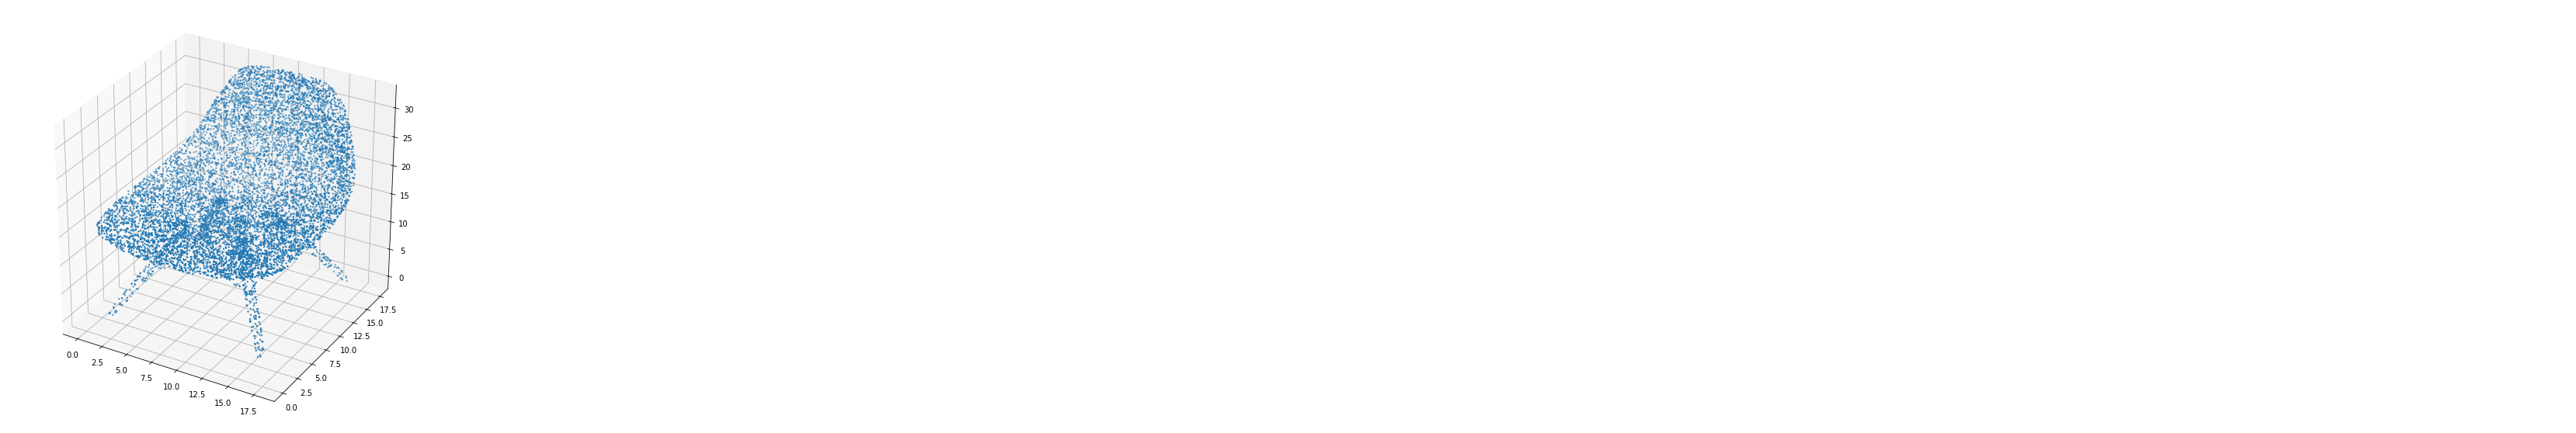

In [29]:
plot3D(test)

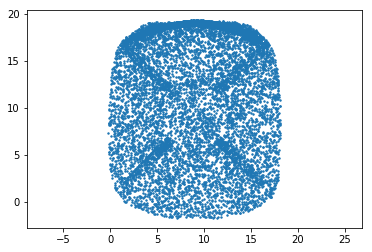

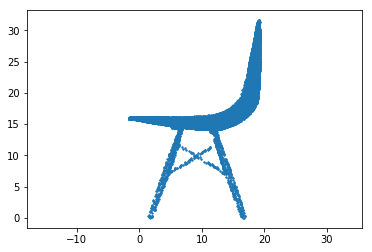

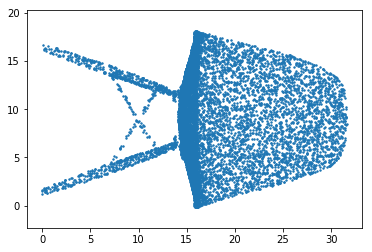

In [30]:
plot_trihedral_figure(test)

In [31]:
#voxelize
test_vox = voxilize(test,cell)

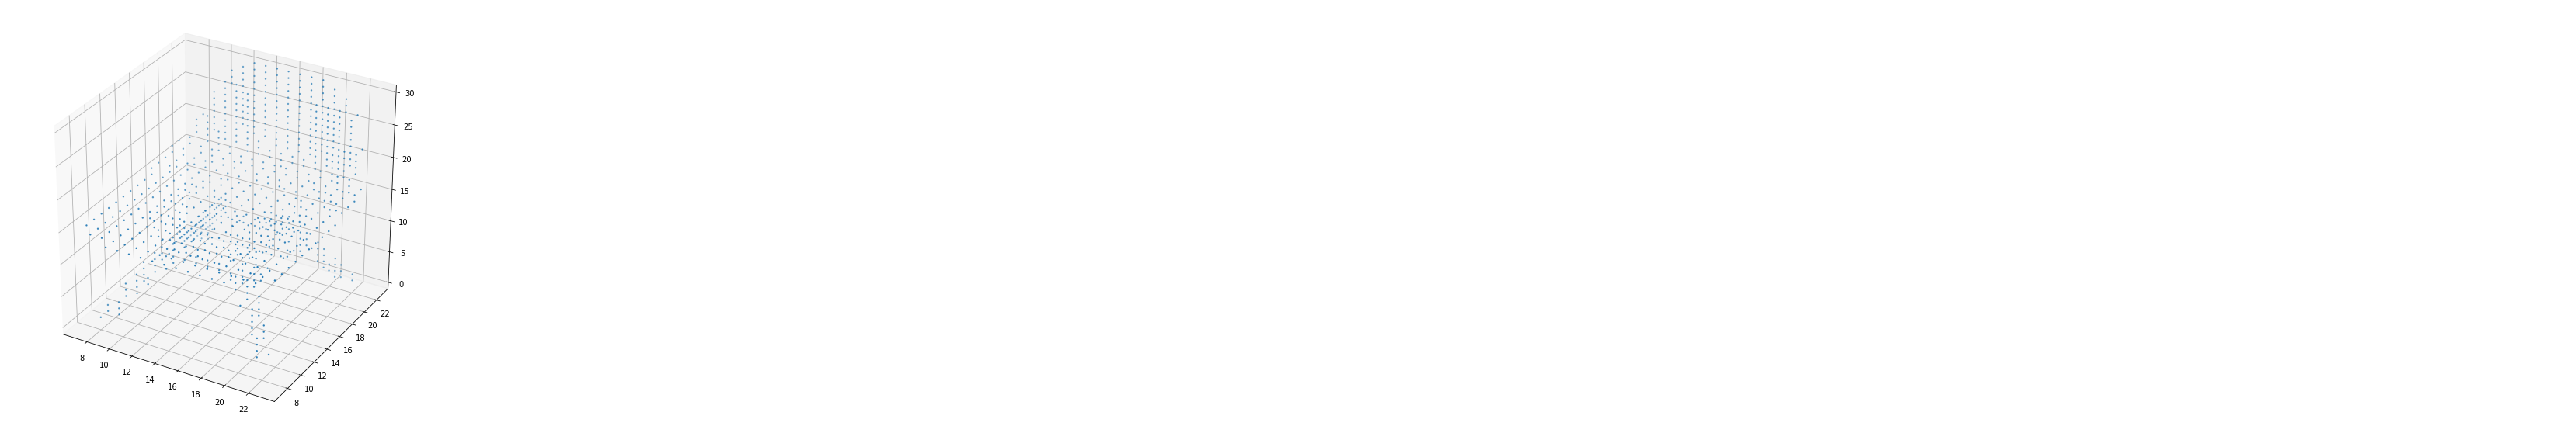

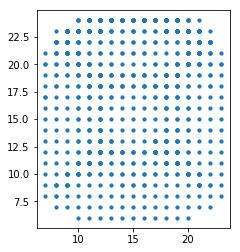

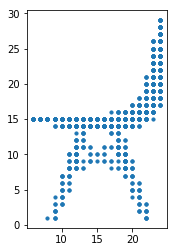

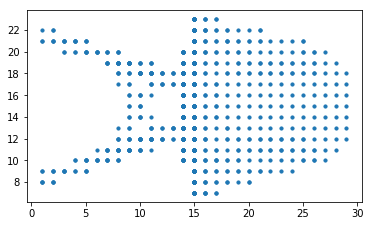

shape is (1, 1, 32, 32, 32)


In [32]:
#turn
vox_scat = voxel_scatter(test_vox)
plot3D(vox_scat)
plot_trihedral_figure_vox(vox_scat)
print("shape is {}".format(test_vox.shape))

##  ボクセルのnumpy保存

In [33]:
off_voxilize = False

for t in train_or_test:
    for cl in  tqdm(class_name_modelnet):
        print(cl)
        
        #すでにボクセル化が済んていればスキップ
        if os.path.exists(vox_dir + "x_train.npy") == True:
#             print("{} is exist.".format(vox_dir + cl + t + ".npy"))
            off_voxilize = True
            continue
        
        #すでに存在してるnpyファイルはスキップ
        if os.path.exists(vox_dir + cl + t + ".npy") == True:
            print("{} is exist.".format(data_dir + cl + t + ".npy"))
            continue
        
        num = glob.glob(data_dir+ cl +"/" + t + "/*")
        for i in tqdm(range(len(num))):
            if i ==0  :
                off = load_vox(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
                continue
            off_ =  load_vox(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
            
            off = np.append(off, off_, axis=0)
        np.save(vox_dir + cl + t + ".npy", off)
#クラス毎，TestTrain毎ボクセル化されたnpzが生成される（N,1,32,32,32）

airplane
bookshelf
chair
desk
glass_box
laptop
person
range_hood
stool
tv_stand
bathtub
bottle
cone
door
guitar
mantel
piano
sink
table
vase
bed
bowl
cup
dresser
keyboard
monitor
plant
sofa
tent
wardrobe
bench
car
curtain
flower_pot
lamp
night_stand
radio
stairs
toilet
xbox



airplane
bookshelf
chair
desk
glass_box
laptop
person
range_hood
stool
tv_stand
bathtub
bottle
cone
door
guitar
mantel
piano
sink
table
vase
bed
bowl
cup
dresser
keyboard
monitor
plant
sofa
tent
wardrobe
bench
car
curtain
flower_pot
lamp
night_stand
radio
stairs
toilet
xbox



In [34]:

#ココらへん可読性わるすぎ
if not off_voxilize:
    # データ整形
    for t in train_or_test:
        swich_npy = True 
        num_of_data = []#init
        for cl in class_name_modelnet:
            if swich_npy == True:
                npy = np.load(vox_dir  + cl + t + ".npy")
                num_of_data.append(npy.shape[0])
                swich_npy = False
            else:
                npy_ = np.load(vox_dir  + cl + t + ".npy")
                npy = np.append(npy,npy_,axis=0)
                num_of_data.append(npy_.shape[0])
        if t == "train":
            x_train = npy
            y_train = num_of_data
        if t == "test":
            x_test = npy
            y_test = num_of_data
            
        
    # ラベルの生成
    for t in train_or_test:
        if t == "train":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_train[i] , i )    
                else:
                    label_ = np.full(y_train[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_train = label

        if t == "test":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_test[i] , i )    
                else:
                    label_ = np.full(y_test[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_test = label


# convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    # 保存
    npy = ["x_train.npy" , "x_test.npy" , "y_train.npy" , "y_test.npy"]
    data = [x_train , x_test , y_train , y_test]
    for i in range(len(npy)):
        np.save(vox_dir + npy[i],data[i])
        
    # 不要ファイルの除去
    for i in os.listdir(vox_dir):
        if not i in npy:
            os.remove(vox_dir + i)

# modelの定義

## optimizer

In [35]:
optimizer = SGD(lr=learning_rate, momentum=0.9, decay=0.00016667, nesterov=False)

## init model

In [36]:
# init model
model = Sequential()

# convolution 1
model.add(Conv3D(input_shape=(1, cell, cell, cell),
                            nb_filter=32,
                            kernel_dim1=5,
                            kernel_dim2=5,
                            kernel_dim3=5,
                            init='normal',
                            border_mode='valid',
                            subsample=(2, 2, 2),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 1
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))



#Activation ReLu
model.add(ReLU())

# dropout 1
model.add(Dropout(p=0.4))

# convolution 2
model.add(Conv3D(nb_filter=32,
                            kernel_dim1=3,
                            kernel_dim2=3,
                            kernel_dim3=3,
                            init='normal',
                            border_mode='valid',
                            subsample=(1, 1, 1),
                            dim_ordering='th',
                            W_regularizer=l2(0.001),
                            b_regularizer=l2(0.001),
                            ))

# # BatchNormalization 2
# model.add(BatchNormalization(axis=-1, 
#                              momentum=0.99, 
#                              epsilon=0.001, 
#                              center=True, 
#                              scale=True, 
#                              beta_initializer='zeros', 
#                              gamma_initializer='ones', 
#                              moving_mean_initializer='zeros', 
#                              moving_variance_initializer='ones', 
#                              beta_regularizer=None, 
#                              gamma_regularizer=None, 
#                              beta_constraint=None, 
#                              gamma_constraint=None))

#Activation ReLu
model.add(ReLU())

# max pool 1
model.add(MaxPooling3D(pool_size=(2, 2, 2),
                           strides=None,
                           border_mode='valid',
                           dim_ordering='th'))

# dropout 2
model.add(Dropout(p=0.4))

# dense 1 (fully connected layer)
model.add(Flatten())

model.add(Dense(output_dim=528, #128
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

# dropout 3
model.add(Dropout(p=0.5))

# dense 2 (fully connected layer)
model.add(Dense(output_dim=num_classes,
                    init='normal',
                    activation='linear',
                    W_regularizer=l2(0.001),
                    b_regularizer=l2(0.001),
                    ))

#Activation Softmax
model.add(Activation("softmax"))


/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(input_shape=(1, 32, 32..., kernel_size=(5, 5, 5), filters=32, strides=(2, 2, 2), padding="valid", data_format="channels_first", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(kernel_size=(3, 3, 3), filters=32, strides=(1, 1, 1), padding="valid", data_format="channels_first", kernel_initializer="normal", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarn

## モデルの保存

In [37]:
#モデルの保存
json_string = model.to_json()
open(model_dir+'voxnet_model.json', 'w').write(json_string)

3813

## modelの読み込み

In [38]:
#モデルの読み込み
model_data = open("model/" + dataset + "/cell" + str(cell) + "/voxnet_model.json").read()
model = model_from_json(model_data)

In [39]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

## モデル可視化

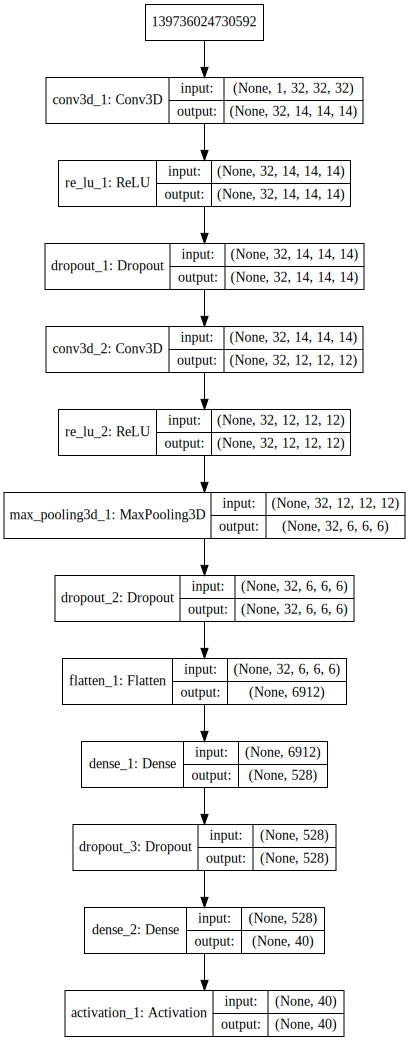

In [40]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

## summary

In [41]:
#サマリーの表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 14, 14, 14)    4032      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 14, 14, 14)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14, 14)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 12, 12, 12)    27680     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 32, 12, 12, 12)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 6, 6, 6)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 6, 6, 6)       0         
__________

In [42]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model.png',show_shapes='True')

In [43]:
model

# Train

## ボクセルのLoad

In [44]:
x_train = np.load( vox_dir  + "x_train.npy")
x_test = np.load( vox_dir  + "x_test.npy")
y_train = np.load( vox_dir + "y_train.npy")
y_test = np.load( vox_dir + "y_test.npy")

In [45]:
x_train.shape

(9843, 1, 32, 32, 32)

In [46]:
y_train.shape

(9843, 40)

In [47]:
x_test.shape

(2468, 1, 32, 32, 32)

In [48]:
y_test.shape

(2468, 40)

## callback

In [49]:
# early_stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

In [50]:
#save best model
checkpoint = ModelCheckpoint(filepath = os.path.join(weights_dir, "model-{epoch:02d}.h5"))

In [51]:
# TensorBoard
callbacks = [make_tensorboard(),checkpoint]

## fit

In [52]:
result = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test) ,
                   callbacks=callbacks)

time_now = datetime.datetime.now()
time_now = "_{0}_{1}_{2}_{3}_{4}_{5}".format(time_now.year, time_now.month, time_now.day,
                                             time_now.hour, time_now.minute, time_now.second)
model.save_weights(weights_dir+"weights_{0}.h5".format(time_now), False)

Train on 9843 samples, validate on 2468 samples
Epoch 1/80
9843/9843 [==============================] - 10s 1ms/step - loss: 11.7639 - acc: 0.3714 - val_loss: 10.6927 - val_acc: 0.5656
Epoch 2/80
9843/9843 [==============================] - 7s 758us/step - loss: 10.3227 - acc: 0.6188 - val_loss: 9.9272 - val_acc: 0.6827
Epoch 3/80
9843/9843 [==============================] - 7s 716us/step - loss: 9.7297 - acc: 0.6956 - val_loss: 9.4605 - val_acc: 0.7472
Epoch 4/80
9843/9843 [==============================] - 6s 633us/step - loss: 9.3159 - acc: 0.7370 - val_loss: 9.1192 - val_acc: 0.7727
Epoch 5/80
9843/9843 [==============================] - 8s 773us/step - loss: 8.9717 - acc: 0.7649 - val_loss: 8.8182 - val_acc: 0.7885
Epoch 6/80
9843/9843 [==============================] - 7s 716us/step - loss: 8.6669 - acc: 0.7824 - val_loss: 8.5192 - val_acc: 0.8035
Epoch 7/80
9843/9843 [==============================] - 6s 642us/step - loss: 8.3940 - acc: 0.7954 - val_loss: 8.2549 - val_acc: 0.805

9843/9843 [==============================] - 7s 728us/step - loss: 2.6722 - acc: 0.9379 - val_loss: 2.9214 - val_acc: 0.8643
Epoch 61/80
9843/9843 [==============================] - 6s 659us/step - loss: 2.6338 - acc: 0.9371 - val_loss: 2.8908 - val_acc: 0.8614
Epoch 62/80
9843/9843 [==============================] - 7s 730us/step - loss: 2.5946 - acc: 0.9347 - val_loss: 2.8493 - val_acc: 0.8630
Epoch 63/80
9843/9843 [==============================] - 7s 722us/step - loss: 2.5493 - acc: 0.9368 - val_loss: 2.8002 - val_acc: 0.8687
Epoch 64/80
9843/9843 [==============================] - 6s 654us/step - loss: 2.5138 - acc: 0.9417 - val_loss: 2.7701 - val_acc: 0.8679
Epoch 65/80
9843/9843 [==============================] - 7s 754us/step - loss: 2.4710 - acc: 0.9403 - val_loss: 2.7339 - val_acc: 0.8683
Epoch 66/80
9843/9843 [==============================] - 7s 726us/step - loss: 2.4333 - acc: 0.9419 - val_loss: 2.7058 - val_acc: 0.8691
Epoch 67/80
9843/9843 [==============================

In [53]:
# # 重みの読み込み
# model.load_weights('weights/ModelNet40/cell32/weights__2018_11_20_17_6_16.h5')

# evaluate

In [54]:
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 2.2889609723268878
Test accuracy: 0.8642625607779578


In [55]:
# 重みを読み込んで評価
model.load_weights("weights/"+dataset+"/cell32/model-38.h5")
loss,acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 4.122967137316637
Test accuracy: 0.8634521880064829


## learning validation curve 

In [56]:
rcParams["figure.figsize"] = [6.4, 4.8]

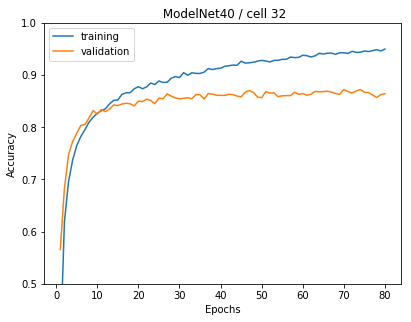

In [57]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc.svg')
plt.show()

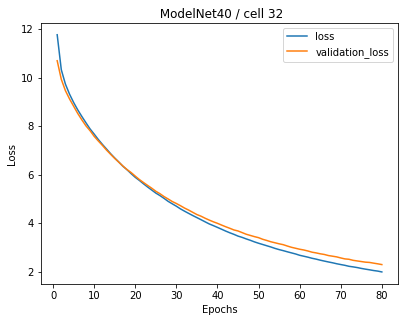

In [58]:
plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label="loss")
plt.plot(range(1, len(result.history['val_loss'])+1), result.history['val_loss'], label="validation_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir  + 'loss.svg')
plt.show()

## Confusion matrix

In [59]:
labels_pred = model.predict_classes(x_test,verbose=0)

In [60]:
labels_pred.shape

(2468,)

In [61]:
labels_pred

array([ 0,  0,  0, ...,  3, 25, 39])

In [62]:
np.argmax(y_test, axis=1)

array([ 0,  0,  0, ..., 39, 39, 39])

In [63]:
# 間違ったやつのIndex
np.where((labels_pred == np.argmax(y_test, axis=1)) == 0)

(array([ 127,  141,  159,  173,  175,  177,  223,  227,  233,  265,  273,
         300,  303,  310,  314,  326,  327,  329,  331,  352,  354,  358,
         365,  371,  377,  379,  380,  398,  429,  451,  466,  468,  480,
         495,  513,  516,  517,  519,  523,  524,  534,  537,  545,  546,
         554,  569,  572,  591,  623,  626,  634,  639,  642,  645,  647,
         648,  656,  658,  660,  661,  664,  665,  684,  692,  697,  698,
         699,  708,  709,  710,  713,  716,  720,  722,  723,  728,  738,
         743,  750,  753,  761,  772,  789,  790,  862,  884,  885,  899,
         914,  924,  946,  957,  972, 1039, 1055, 1057, 1068, 1074, 1083,
        1089, 1091, 1099, 1138, 1142, 1155, 1158, 1159, 1166, 1173, 1174,
        1179, 1187, 1189, 1194, 1204, 1210, 1214, 1230, 1233, 1238, 1244,
        1245, 1246, 1250, 1252, 1253, 1255, 1259, 1260, 1262, 1264, 1271,
        1274, 1275, 1278, 1279, 1282, 1284, 1287, 1290, 1291, 1298, 1308,
        1314, 1325, 1327, 1330, 1331, 

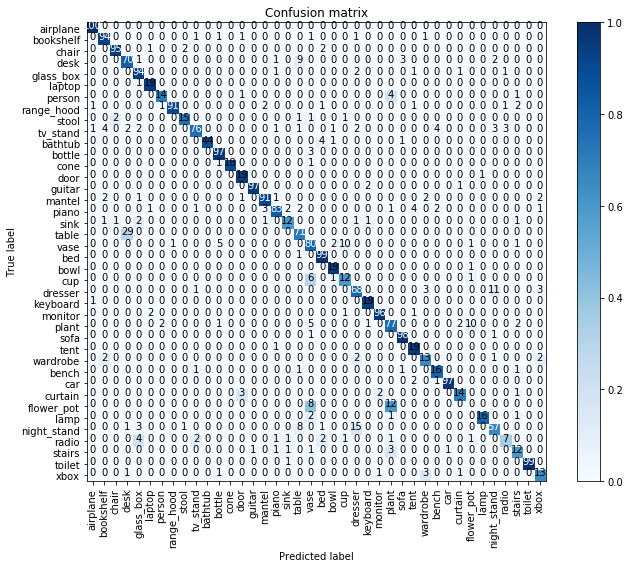

In [64]:
# グラフのサイズ
rcParams['figure.figsize'] = 10,8


# Plot normalized confusion matrix
plot_confusion_matrix(x_test,y_test)


## 個別に分類

In [65]:
vertices, faces = load_off(dataset+"/chair/train/0.off")
points = gen_random_points(vertices, faces, n_points)
# ValueError: sequence too large; cannot be greater than 32の回避策
# list 2 numpy.ndarray
test = np.empty((len(points), len(points[0])))
test[:] = points
print(type(test))
#voxelize
test_vox = voxilize(test,cell)

<class 'numpy.ndarray'>


In [66]:
model.load_weights('weights/'+dataset+'/cell32/model-40.h5')

# 読み込んだ学習済みモデルで予測
proba_all = model.predict(test_vox)
print(proba_all)
proba = np.argmax(proba_all)
print(proba_all[0][proba])
print(class_name_modelnet[proba])

[[2.42e-07 2.51e-08 1.00e+00 5.40e-09 1.30e-11 2.42e-07 1.18e-07 4.75e-09
  7.10e-06 4.00e-08 8.75e-09 1.54e-09 7.37e-08 3.28e-09 4.36e-09 5.00e-10
  1.32e-07 3.79e-06 2.42e-08 6.97e-07 2.54e-06 1.15e-06 9.04e-07 4.65e-10
  4.37e-06 6.54e-10 1.98e-06 7.13e-09 2.33e-10 1.27e-10 3.90e-08 4.99e-09
  8.11e-10 1.21e-06 5.74e-08 5.67e-08 4.20e-10 2.26e-05 4.11e-05 1.21e-09]]
0.99991155
chair


# TODO MEMO


なんもわからん．．．


tensorboard --logdir=/home/takitani/git/ModelNet2np/TensorBoard

# 距離の計算

In [144]:
dist_calcrated = False
for t in train_or_test:
    for cl in  tqdm(class_name_modelnet):
        print(cl)
        
        #すでに距離の計算が済んていればスキップ
        if os.path.exists(dist_dir + "x_train.npy") == True:
#             print("{} is exist.".format(vox_dir + cl + t + ".npy"))
            dist_calcrated = True
            continue
        
        #すでに存在してるnpyファイルはスキップ
        if os.path.exists(dist_dir + cl + t + ".npy") == True:
#             print("{} is exist.".format(data_dir + cl + t + ".npy"))
            continue
        
        num = glob.glob(data_dir+ cl +"/" + t + "/*")
        for i in tqdm(range(len(num))):
            if i ==0  :
                dist = calc_dist(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
                dist = [dist]
                continue
            dist_ =  calc_dist(data_dir + cl + "/" + t +"/"+ str(i) + ".off")
            
            dist = np.append(dist, [dist_], axis=0)
#             print(dist.shape)
        np.save(dist_dir + cl + t + ".npy", dist)

airplane


bookshelf


chair


ModelNet40/chair/train/94.off is broken!!
ModelNet40/chair/train/359.off is broken!!
ModelNet40/chair/train/650.off is broken!!
ModelNet40/chair/train/825.off is broken!!
desk


ModelNet40/desk/train/0.off is broken!!
ModelNet40/desk/train/1.off is broken!!
ModelNet40/desk/train/2.off is broken!!
ModelNet40/desk/train/3.off is broken!!
ModelNet40/desk/train/4.off is broken!!
ModelNet40/desk/train/5.off is broken!!
ModelNet40/desk/train/6.off is broken!!
ModelNet40/desk/train/7.off is broken!!
ModelNet40/desk/train/8.off is broken!!
ModelNet40/desk/train/9.off is broken!!
ModelNet40/desk/train/10.off is broken!!
ModelNet40/desk/train/11.off is broken!!
ModelNet40/desk/train/12.off is broken!!
ModelNet40/desk/train/13.off is broken!!
ModelNet40/desk/train/14.off is broken!!
ModelNet40/desk/train/15.off is broken!!
ModelNet40/desk/train/16.off is broken!!
ModelNet40/desk/train/17.off is broken!!
ModelNet40/desk/train/18.off is broken!!
ModelNet40/desk/train/19.off is broken!!
ModelNet40/desk/train/20.off is broken!!
ModelNet40/desk/train/21.off is broken!!
ModelNet40/desk/train/22.off is broken!!
ModelNet40/desk/train/23.off is broken!!
ModelNet40/desk/train/24.o

laptop


person


range_hood


stool


tv_stand


bathtub


ModelNet40/bathtub/train/0.off is broken!!
ModelNet40/bathtub/train/1.off is broken!!
ModelNet40/bathtub/train/2.off is broken!!
ModelNet40/bathtub/train/3.off is broken!!
ModelNet40/bathtub/train/4.off is broken!!
ModelNet40/bathtub/train/5.off is broken!!
ModelNet40/bathtub/train/6.off is broken!!
ModelNet40/bathtub/train/7.off is broken!!
ModelNet40/bathtub/train/8.off is broken!!
ModelNet40/bathtub/train/9.off is broken!!
ModelNet40/bathtub/train/10.off is broken!!
ModelNet40/bathtub/train/11.off is broken!!
ModelNet40/bathtub/train/12.off is broken!!
ModelNet40/bathtub/train/13.off is broken!!
ModelNet40/bathtub/train/14.off is broken!!
ModelNet40/bathtub/train/15.off is broken!!
ModelNet40/bathtub/train/16.off is broken!!
ModelNet40/bathtub/train/17.off is broken!!
ModelNet40/bathtub/train/18.off is broken!!
ModelNet40/bathtub/train/19.off is broken!!
ModelNet40/bathtub/train/20.off is broken!!
ModelNet40/bathtub/train/21.off is broken!!
ModelNet40/bathtub/train/22.off is broken!

cone


door


guitar


mantel


piano


sink


table


ModelNet40/table/train/0.off is broken!!
ModelNet40/table/train/1.off is broken!!
ModelNet40/table/train/2.off is broken!!
ModelNet40/table/train/3.off is broken!!
ModelNet40/table/train/4.off is broken!!
ModelNet40/table/train/5.off is broken!!
ModelNet40/table/train/6.off is broken!!
ModelNet40/table/train/7.off is broken!!
ModelNet40/table/train/8.off is broken!!
ModelNet40/table/train/9.off is broken!!
ModelNet40/table/train/10.off is broken!!
ModelNet40/table/train/11.off is broken!!
ModelNet40/table/train/12.off is broken!!
ModelNet40/table/train/13.off is broken!!
ModelNet40/table/train/14.off is broken!!
ModelNet40/table/train/15.off is broken!!
ModelNet40/table/train/16.off is broken!!
ModelNet40/table/train/17.off is broken!!
ModelNet40/table/train/18.off is broken!!
ModelNet40/table/train/19.off is broken!!
ModelNet40/table/train/20.off is broken!!
ModelNet40/table/train/21.off is broken!!
ModelNet40/table/train/22.off is broken!!
ModelNet40/table/train/23.off is broken!!
Mo

ModelNet40/table/train/214.off is broken!!
ModelNet40/table/train/215.off is broken!!
ModelNet40/table/train/216.off is broken!!
ModelNet40/table/train/217.off is broken!!
ModelNet40/table/train/218.off is broken!!
ModelNet40/table/train/219.off is broken!!
ModelNet40/table/train/220.off is broken!!
ModelNet40/table/train/221.off is broken!!
ModelNet40/table/train/222.off is broken!!
ModelNet40/table/train/223.off is broken!!
ModelNet40/table/train/224.off is broken!!
ModelNet40/table/train/225.off is broken!!
ModelNet40/table/train/226.off is broken!!
ModelNet40/table/train/227.off is broken!!
ModelNet40/table/train/228.off is broken!!
ModelNet40/table/train/229.off is broken!!
ModelNet40/table/train/230.off is broken!!
ModelNet40/table/train/231.off is broken!!
ModelNet40/table/train/232.off is broken!!
ModelNet40/table/train/233.off is broken!!
ModelNet40/table/train/234.off is broken!!
ModelNet40/table/train/235.off is broken!!
ModelNet40/table/train/236.off is broken!!
ModelNet40/

bed


ModelNet40/bed/train/38.off is broken!!
ModelNet40/bed/train/46.off is broken!!
ModelNet40/bed/train/140.off is broken!!
ModelNet40/bed/train/188.off is broken!!
ModelNet40/bed/train/191.off is broken!!
ModelNet40/bed/train/192.off is broken!!
ModelNet40/bed/train/330.off is broken!!
bowl


cup


dresser


ModelNet40/dresser/train/0.off is broken!!
ModelNet40/dresser/train/1.off is broken!!
ModelNet40/dresser/train/2.off is broken!!
ModelNet40/dresser/train/3.off is broken!!
ModelNet40/dresser/train/4.off is broken!!
ModelNet40/dresser/train/5.off is broken!!
ModelNet40/dresser/train/6.off is broken!!
ModelNet40/dresser/train/7.off is broken!!
ModelNet40/dresser/train/8.off is broken!!
ModelNet40/dresser/train/9.off is broken!!
ModelNet40/dresser/train/10.off is broken!!
ModelNet40/dresser/train/11.off is broken!!
ModelNet40/dresser/train/12.off is broken!!
ModelNet40/dresser/train/13.off is broken!!
ModelNet40/dresser/train/14.off is broken!!
ModelNet40/dresser/train/15.off is broken!!
ModelNet40/dresser/train/16.off is broken!!
ModelNet40/dresser/train/17.off is broken!!
ModelNet40/dresser/train/18.off is broken!!
ModelNet40/dresser/train/19.off is broken!!
ModelNet40/dresser/train/20.off is broken!!
ModelNet40/dresser/train/21.off is broken!!
ModelNet40/dresser/train/22.off is broken!

ModelNet40/dresser/train/188.off is broken!!
ModelNet40/dresser/train/189.off is broken!!
ModelNet40/dresser/train/190.off is broken!!
ModelNet40/dresser/train/191.off is broken!!
ModelNet40/dresser/train/192.off is broken!!
ModelNet40/dresser/train/193.off is broken!!
ModelNet40/dresser/train/194.off is broken!!
ModelNet40/dresser/train/195.off is broken!!
ModelNet40/dresser/train/196.off is broken!!
ModelNet40/dresser/train/197.off is broken!!
ModelNet40/dresser/train/198.off is broken!!
ModelNet40/dresser/train/199.off is broken!!
keyboard


monitor


ModelNet40/monitor/train/0.off is broken!!
ModelNet40/monitor/train/1.off is broken!!
ModelNet40/monitor/train/2.off is broken!!
ModelNet40/monitor/train/3.off is broken!!
ModelNet40/monitor/train/4.off is broken!!
ModelNet40/monitor/train/5.off is broken!!
ModelNet40/monitor/train/6.off is broken!!
ModelNet40/monitor/train/7.off is broken!!
ModelNet40/monitor/train/8.off is broken!!
ModelNet40/monitor/train/9.off is broken!!
ModelNet40/monitor/train/10.off is broken!!
ModelNet40/monitor/train/11.off is broken!!
ModelNet40/monitor/train/12.off is broken!!
ModelNet40/monitor/train/13.off is broken!!
ModelNet40/monitor/train/14.off is broken!!
ModelNet40/monitor/train/15.off is broken!!
ModelNet40/monitor/train/16.off is broken!!
ModelNet40/monitor/train/17.off is broken!!
ModelNet40/monitor/train/18.off is broken!!
ModelNet40/monitor/train/19.off is broken!!
ModelNet40/monitor/train/20.off is broken!!
ModelNet40/monitor/train/21.off is broken!!
ModelNet40/monitor/train/22.off is broken!

ModelNet40/monitor/train/191.off is broken!!
ModelNet40/monitor/train/192.off is broken!!
ModelNet40/monitor/train/193.off is broken!!
ModelNet40/monitor/train/194.off is broken!!
ModelNet40/monitor/train/195.off is broken!!
ModelNet40/monitor/train/196.off is broken!!
ModelNet40/monitor/train/197.off is broken!!
ModelNet40/monitor/train/198.off is broken!!
ModelNet40/monitor/train/199.off is broken!!
ModelNet40/monitor/train/200.off is broken!!
ModelNet40/monitor/train/201.off is broken!!
ModelNet40/monitor/train/202.off is broken!!
ModelNet40/monitor/train/203.off is broken!!
ModelNet40/monitor/train/204.off is broken!!
ModelNet40/monitor/train/205.off is broken!!
ModelNet40/monitor/train/206.off is broken!!
ModelNet40/monitor/train/207.off is broken!!
ModelNet40/monitor/train/208.off is broken!!
ModelNet40/monitor/train/209.off is broken!!
ModelNet40/monitor/train/210.off is broken!!
ModelNet40/monitor/train/211.off is broken!!
ModelNet40/monitor/train/212.off is broken!!
ModelNet40

ModelNet40/monitor/train/394.off is broken!!
ModelNet40/monitor/train/395.off is broken!!
ModelNet40/monitor/train/396.off is broken!!
ModelNet40/monitor/train/397.off is broken!!
ModelNet40/monitor/train/398.off is broken!!
ModelNet40/monitor/train/399.off is broken!!
ModelNet40/monitor/train/400.off is broken!!
ModelNet40/monitor/train/401.off is broken!!
ModelNet40/monitor/train/402.off is broken!!
ModelNet40/monitor/train/403.off is broken!!
ModelNet40/monitor/train/404.off is broken!!
ModelNet40/monitor/train/405.off is broken!!
ModelNet40/monitor/train/406.off is broken!!
ModelNet40/monitor/train/407.off is broken!!
ModelNet40/monitor/train/408.off is broken!!
ModelNet40/monitor/train/409.off is broken!!
ModelNet40/monitor/train/410.off is broken!!
ModelNet40/monitor/train/411.off is broken!!
ModelNet40/monitor/train/412.off is broken!!
ModelNet40/monitor/train/413.off is broken!!
ModelNet40/monitor/train/414.off is broken!!
ModelNet40/monitor/train/415.off is broken!!
ModelNet40

sofa


ModelNet40/sofa/train/0.off is broken!!
ModelNet40/sofa/train/1.off is broken!!
ModelNet40/sofa/train/2.off is broken!!
ModelNet40/sofa/train/3.off is broken!!
ModelNet40/sofa/train/4.off is broken!!
ModelNet40/sofa/train/5.off is broken!!
ModelNet40/sofa/train/6.off is broken!!
ModelNet40/sofa/train/7.off is broken!!
ModelNet40/sofa/train/8.off is broken!!
ModelNet40/sofa/train/9.off is broken!!
ModelNet40/sofa/train/10.off is broken!!
ModelNet40/sofa/train/11.off is broken!!
ModelNet40/sofa/train/12.off is broken!!
ModelNet40/sofa/train/13.off is broken!!
ModelNet40/sofa/train/14.off is broken!!
ModelNet40/sofa/train/15.off is broken!!
ModelNet40/sofa/train/16.off is broken!!
ModelNet40/sofa/train/17.off is broken!!
ModelNet40/sofa/train/18.off is broken!!
ModelNet40/sofa/train/19.off is broken!!
ModelNet40/sofa/train/20.off is broken!!
ModelNet40/sofa/train/21.off is broken!!
ModelNet40/sofa/train/22.off is broken!!
ModelNet40/sofa/train/23.off is broken!!
ModelNet40/sofa/train/24.o

ModelNet40/sofa/train/200.off is broken!!
ModelNet40/sofa/train/201.off is broken!!
ModelNet40/sofa/train/202.off is broken!!
ModelNet40/sofa/train/203.off is broken!!
ModelNet40/sofa/train/204.off is broken!!
ModelNet40/sofa/train/205.off is broken!!
ModelNet40/sofa/train/206.off is broken!!
ModelNet40/sofa/train/207.off is broken!!
ModelNet40/sofa/train/208.off is broken!!
ModelNet40/sofa/train/209.off is broken!!
ModelNet40/sofa/train/210.off is broken!!
ModelNet40/sofa/train/211.off is broken!!
ModelNet40/sofa/train/212.off is broken!!
ModelNet40/sofa/train/213.off is broken!!
ModelNet40/sofa/train/214.off is broken!!
ModelNet40/sofa/train/215.off is broken!!
ModelNet40/sofa/train/216.off is broken!!
ModelNet40/sofa/train/217.off is broken!!
ModelNet40/sofa/train/218.off is broken!!
ModelNet40/sofa/train/219.off is broken!!
ModelNet40/sofa/train/220.off is broken!!
ModelNet40/sofa/train/221.off is broken!!
ModelNet40/sofa/train/222.off is broken!!
ModelNet40/sofa/train/223.off is b

ModelNet40/sofa/train/402.off is broken!!
ModelNet40/sofa/train/403.off is broken!!
ModelNet40/sofa/train/404.off is broken!!
ModelNet40/sofa/train/405.off is broken!!
ModelNet40/sofa/train/406.off is broken!!
ModelNet40/sofa/train/407.off is broken!!
ModelNet40/sofa/train/408.off is broken!!
ModelNet40/sofa/train/409.off is broken!!
ModelNet40/sofa/train/410.off is broken!!
ModelNet40/sofa/train/411.off is broken!!
ModelNet40/sofa/train/412.off is broken!!
ModelNet40/sofa/train/413.off is broken!!
ModelNet40/sofa/train/414.off is broken!!
ModelNet40/sofa/train/415.off is broken!!
ModelNet40/sofa/train/416.off is broken!!
ModelNet40/sofa/train/417.off is broken!!
ModelNet40/sofa/train/418.off is broken!!
ModelNet40/sofa/train/419.off is broken!!
ModelNet40/sofa/train/420.off is broken!!
ModelNet40/sofa/train/421.off is broken!!
ModelNet40/sofa/train/422.off is broken!!
ModelNet40/sofa/train/423.off is broken!!
ModelNet40/sofa/train/424.off is broken!!
ModelNet40/sofa/train/425.off is b

ModelNet40/sofa/train/602.off is broken!!
ModelNet40/sofa/train/603.off is broken!!
ModelNet40/sofa/train/604.off is broken!!
ModelNet40/sofa/train/605.off is broken!!
ModelNet40/sofa/train/606.off is broken!!
ModelNet40/sofa/train/607.off is broken!!
ModelNet40/sofa/train/608.off is broken!!
ModelNet40/sofa/train/609.off is broken!!
ModelNet40/sofa/train/610.off is broken!!
ModelNet40/sofa/train/611.off is broken!!
ModelNet40/sofa/train/612.off is broken!!
ModelNet40/sofa/train/613.off is broken!!
ModelNet40/sofa/train/614.off is broken!!
ModelNet40/sofa/train/615.off is broken!!
ModelNet40/sofa/train/616.off is broken!!
ModelNet40/sofa/train/617.off is broken!!
ModelNet40/sofa/train/618.off is broken!!
ModelNet40/sofa/train/619.off is broken!!
ModelNet40/sofa/train/620.off is broken!!
ModelNet40/sofa/train/621.off is broken!!
ModelNet40/sofa/train/622.off is broken!!
ModelNet40/sofa/train/623.off is broken!!
ModelNet40/sofa/train/624.off is broken!!
ModelNet40/sofa/train/625.off is b

wardrobe


bench


car


curtain


flower_pot


lamp


night_stand


ModelNet40/night_stand/train/0.off is broken!!
ModelNet40/night_stand/train/1.off is broken!!
ModelNet40/night_stand/train/2.off is broken!!
ModelNet40/night_stand/train/3.off is broken!!
ModelNet40/night_stand/train/4.off is broken!!
ModelNet40/night_stand/train/5.off is broken!!
ModelNet40/night_stand/train/6.off is broken!!
ModelNet40/night_stand/train/7.off is broken!!
ModelNet40/night_stand/train/8.off is broken!!
ModelNet40/night_stand/train/9.off is broken!!
ModelNet40/night_stand/train/10.off is broken!!
ModelNet40/night_stand/train/11.off is broken!!
ModelNet40/night_stand/train/12.off is broken!!
ModelNet40/night_stand/train/13.off is broken!!
ModelNet40/night_stand/train/14.off is broken!!
ModelNet40/night_stand/train/15.off is broken!!
ModelNet40/night_stand/train/16.off is broken!!
ModelNet40/night_stand/train/17.off is broken!!
ModelNet40/night_stand/train/18.off is broken!!
ModelNet40/night_stand/train/19.off is broken!!
ModelNet40/night_stand/train/20.off is broken!!
Mo

ModelNet40/night_stand/train/173.off is broken!!
ModelNet40/night_stand/train/174.off is broken!!
ModelNet40/night_stand/train/175.off is broken!!
ModelNet40/night_stand/train/176.off is broken!!
ModelNet40/night_stand/train/177.off is broken!!
ModelNet40/night_stand/train/178.off is broken!!
ModelNet40/night_stand/train/179.off is broken!!
ModelNet40/night_stand/train/180.off is broken!!
ModelNet40/night_stand/train/181.off is broken!!
ModelNet40/night_stand/train/182.off is broken!!
ModelNet40/night_stand/train/183.off is broken!!
ModelNet40/night_stand/train/184.off is broken!!
ModelNet40/night_stand/train/185.off is broken!!
ModelNet40/night_stand/train/186.off is broken!!
ModelNet40/night_stand/train/187.off is broken!!
ModelNet40/night_stand/train/188.off is broken!!
ModelNet40/night_stand/train/189.off is broken!!
ModelNet40/night_stand/train/190.off is broken!!
ModelNet40/night_stand/train/191.off is broken!!
ModelNet40/night_stand/train/192.off is broken!!
ModelNet40/night_sta

stairs


toilet


xbox


airplane


bookshelf


chair


desk


ModelNet40/desk/test/0.off is broken!!
ModelNet40/desk/test/1.off is broken!!
ModelNet40/desk/test/2.off is broken!!
ModelNet40/desk/test/3.off is broken!!
ModelNet40/desk/test/4.off is broken!!
ModelNet40/desk/test/5.off is broken!!
ModelNet40/desk/test/6.off is broken!!
ModelNet40/desk/test/7.off is broken!!
ModelNet40/desk/test/8.off is broken!!
ModelNet40/desk/test/9.off is broken!!
ModelNet40/desk/test/10.off is broken!!
ModelNet40/desk/test/11.off is broken!!
ModelNet40/desk/test/12.off is broken!!
ModelNet40/desk/test/13.off is broken!!
ModelNet40/desk/test/14.off is broken!!
ModelNet40/desk/test/15.off is broken!!
ModelNet40/desk/test/16.off is broken!!
ModelNet40/desk/test/17.off is broken!!
ModelNet40/desk/test/18.off is broken!!
ModelNet40/desk/test/19.off is broken!!
ModelNet40/desk/test/20.off is broken!!
ModelNet40/desk/test/21.off is broken!!
ModelNet40/desk/test/22.off is broken!!
ModelNet40/desk/test/23.off is broken!!
ModelNet40/desk/test/24.off is broken!!
ModelNet40

laptop


person


range_hood


stool


tv_stand


bathtub


ModelNet40/bathtub/test/0.off is broken!!
ModelNet40/bathtub/test/1.off is broken!!
ModelNet40/bathtub/test/2.off is broken!!
ModelNet40/bathtub/test/3.off is broken!!
ModelNet40/bathtub/test/4.off is broken!!
ModelNet40/bathtub/test/5.off is broken!!
ModelNet40/bathtub/test/6.off is broken!!
ModelNet40/bathtub/test/7.off is broken!!
ModelNet40/bathtub/test/8.off is broken!!
ModelNet40/bathtub/test/9.off is broken!!
ModelNet40/bathtub/test/10.off is broken!!
ModelNet40/bathtub/test/11.off is broken!!
ModelNet40/bathtub/test/12.off is broken!!
ModelNet40/bathtub/test/13.off is broken!!
ModelNet40/bathtub/test/14.off is broken!!
ModelNet40/bathtub/test/15.off is broken!!
ModelNet40/bathtub/test/16.off is broken!!
ModelNet40/bathtub/test/17.off is broken!!
ModelNet40/bathtub/test/18.off is broken!!
ModelNet40/bathtub/test/19.off is broken!!
ModelNet40/bathtub/test/20.off is broken!!
ModelNet40/bathtub/test/21.off is broken!!
ModelNet40/bathtub/test/22.off is broken!!
ModelNet40/bathtub/te

cone


door


guitar


mantel


piano


sink


table


ModelNet40/table/test/0.off is broken!!
ModelNet40/table/test/1.off is broken!!
ModelNet40/table/test/2.off is broken!!
ModelNet40/table/test/3.off is broken!!
ModelNet40/table/test/4.off is broken!!
ModelNet40/table/test/5.off is broken!!
ModelNet40/table/test/6.off is broken!!
ModelNet40/table/test/7.off is broken!!
ModelNet40/table/test/8.off is broken!!
ModelNet40/table/test/9.off is broken!!
ModelNet40/table/test/10.off is broken!!
ModelNet40/table/test/11.off is broken!!
ModelNet40/table/test/12.off is broken!!
ModelNet40/table/test/13.off is broken!!
ModelNet40/table/test/14.off is broken!!
ModelNet40/table/test/15.off is broken!!
ModelNet40/table/test/16.off is broken!!
ModelNet40/table/test/17.off is broken!!
ModelNet40/table/test/18.off is broken!!
ModelNet40/table/test/19.off is broken!!
ModelNet40/table/test/20.off is broken!!
ModelNet40/table/test/21.off is broken!!
ModelNet40/table/test/22.off is broken!!
ModelNet40/table/test/23.off is broken!!
ModelNet40/table/test/24.o

bed


bowl


cup


dresser


ModelNet40/dresser/test/0.off is broken!!
ModelNet40/dresser/test/1.off is broken!!
ModelNet40/dresser/test/2.off is broken!!
ModelNet40/dresser/test/3.off is broken!!
ModelNet40/dresser/test/4.off is broken!!
ModelNet40/dresser/test/5.off is broken!!
ModelNet40/dresser/test/6.off is broken!!
ModelNet40/dresser/test/7.off is broken!!
ModelNet40/dresser/test/8.off is broken!!
ModelNet40/dresser/test/9.off is broken!!
ModelNet40/dresser/test/10.off is broken!!
ModelNet40/dresser/test/11.off is broken!!
ModelNet40/dresser/test/12.off is broken!!
ModelNet40/dresser/test/13.off is broken!!
ModelNet40/dresser/test/14.off is broken!!
ModelNet40/dresser/test/15.off is broken!!
ModelNet40/dresser/test/16.off is broken!!
ModelNet40/dresser/test/17.off is broken!!
ModelNet40/dresser/test/18.off is broken!!
ModelNet40/dresser/test/19.off is broken!!
ModelNet40/dresser/test/20.off is broken!!
ModelNet40/dresser/test/21.off is broken!!
ModelNet40/dresser/test/22.off is broken!!
ModelNet40/dresser/te

monitor


ModelNet40/monitor/test/0.off is broken!!
ModelNet40/monitor/test/1.off is broken!!
ModelNet40/monitor/test/2.off is broken!!
ModelNet40/monitor/test/3.off is broken!!
ModelNet40/monitor/test/4.off is broken!!
ModelNet40/monitor/test/5.off is broken!!
ModelNet40/monitor/test/6.off is broken!!
ModelNet40/monitor/test/7.off is broken!!
ModelNet40/monitor/test/8.off is broken!!
ModelNet40/monitor/test/9.off is broken!!
ModelNet40/monitor/test/10.off is broken!!
ModelNet40/monitor/test/11.off is broken!!
ModelNet40/monitor/test/12.off is broken!!
ModelNet40/monitor/test/13.off is broken!!
ModelNet40/monitor/test/14.off is broken!!
ModelNet40/monitor/test/15.off is broken!!
ModelNet40/monitor/test/16.off is broken!!
ModelNet40/monitor/test/17.off is broken!!
ModelNet40/monitor/test/18.off is broken!!
ModelNet40/monitor/test/19.off is broken!!
ModelNet40/monitor/test/20.off is broken!!
ModelNet40/monitor/test/21.off is broken!!
ModelNet40/monitor/test/22.off is broken!!
ModelNet40/monitor/te

sofa


ModelNet40/sofa/test/0.off is broken!!
ModelNet40/sofa/test/1.off is broken!!
ModelNet40/sofa/test/2.off is broken!!
ModelNet40/sofa/test/3.off is broken!!
ModelNet40/sofa/test/4.off is broken!!
ModelNet40/sofa/test/5.off is broken!!
ModelNet40/sofa/test/6.off is broken!!
ModelNet40/sofa/test/7.off is broken!!
ModelNet40/sofa/test/8.off is broken!!
ModelNet40/sofa/test/9.off is broken!!
ModelNet40/sofa/test/10.off is broken!!
ModelNet40/sofa/test/11.off is broken!!
ModelNet40/sofa/test/12.off is broken!!
ModelNet40/sofa/test/13.off is broken!!
ModelNet40/sofa/test/14.off is broken!!
ModelNet40/sofa/test/15.off is broken!!
ModelNet40/sofa/test/16.off is broken!!
ModelNet40/sofa/test/17.off is broken!!
ModelNet40/sofa/test/18.off is broken!!
ModelNet40/sofa/test/19.off is broken!!
ModelNet40/sofa/test/20.off is broken!!
ModelNet40/sofa/test/21.off is broken!!
ModelNet40/sofa/test/22.off is broken!!
ModelNet40/sofa/test/23.off is broken!!
ModelNet40/sofa/test/24.off is broken!!
ModelNet40

wardrobe


bench


car


curtain


flower_pot


lamp


night_stand


ModelNet40/night_stand/test/0.off is broken!!
ModelNet40/night_stand/test/1.off is broken!!
ModelNet40/night_stand/test/2.off is broken!!
ModelNet40/night_stand/test/3.off is broken!!
ModelNet40/night_stand/test/4.off is broken!!
ModelNet40/night_stand/test/5.off is broken!!
ModelNet40/night_stand/test/6.off is broken!!
ModelNet40/night_stand/test/7.off is broken!!
ModelNet40/night_stand/test/8.off is broken!!
ModelNet40/night_stand/test/9.off is broken!!
ModelNet40/night_stand/test/10.off is broken!!
ModelNet40/night_stand/test/11.off is broken!!
ModelNet40/night_stand/test/12.off is broken!!
ModelNet40/night_stand/test/13.off is broken!!
ModelNet40/night_stand/test/14.off is broken!!
ModelNet40/night_stand/test/15.off is broken!!
ModelNet40/night_stand/test/16.off is broken!!
ModelNet40/night_stand/test/17.off is broken!!
ModelNet40/night_stand/test/18.off is broken!!
ModelNet40/night_stand/test/19.off is broken!!
ModelNet40/night_stand/test/20.off is broken!!
ModelNet40/night_stand/

stairs


toilet


xbox


In [150]:
#ココらへん可読性わるすぎ
if not dist_calcrated:
    # データ整形
    for t in train_or_test:
        swich_npy = True 
        num_of_data = []#init
        for cl in class_name_modelnet:
            if swich_npy == True:
                npy = np.load(dist_dir  + cl + t + ".npy")
                num_of_data.append(npy.shape[0])
                swich_npy = False
            else:
                npy_ = np.load(dist_dir  + cl + t + ".npy")
                npy = np.append(npy,npy_,axis=0)
                num_of_data.append(npy_.shape[0])
        if t == "train":
            x_train = npy
            y_train = num_of_data
        if t == "test":
            x_test = npy
            y_test = num_of_data
            
        
    # ラベルの生成
    for t in train_or_test:
        if t == "train":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_train[i] , i )    
                else:
                    label_ = np.full(y_train[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_train = label

        if t == "test":
            for i in range(num_classes):
                if i == 0:
                    label = np.full(y_test[i] , i )    
                else:
                    label_ = np.full(y_test[i] , i )   
                    label = np.append(label, label_, axis=0)
            y_test = label


# convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    # 保存
    npy = ["x_train.npy" , "x_test.npy" , "y_train.npy" , "y_test.npy"]
    data = [x_train , x_test , y_train , y_test]
    for i in range(len(npy)):
        np.save(dist_dir + npy[i],data[i])
        
    # 不要ファイルの除去
#     for i in os.listdir(dist_dir):
#         if not i in npy:
#             os.remove(dist_dir + i)

In [152]:
np.load("dist/ModelNet40/cell32/x_train.npy").shape

(9843, 3)